In [1]:
import cv2
import numpy as np
from pandas import DataFrame, read_csv
from matplotlib import pyplot as plt
from shutil import copy2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten,
                                     GlobalMaxPooling2D, LeakyReLU, concatenate, Dropout)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam, Adamax
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from os.path import isfile

In [2]:
SEED = 42

In [3]:
y_filename='training_solutions_rev1.csv'
y = read_csv(y_filename, index_col=0)[['Class1.1','Class1.2','Class1.3']]

In [4]:
crop_shape = (256,256)
input_shape = (96,96)

In [5]:
def create_model(input_shape=(input_shape[0],input_shape[1],3)):
    return Sequential([
        Input(shape=input_shape),
        
        Conv2D(8,(3,3), padding='same', input_shape=input_shape),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        
        Conv2D(16,(3,3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        
        Conv2D(8,(3,3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        
        #Conv2D(4,(3,3), padding='same'),
        #Activation('relu'),
        #MaxPooling2D(pool_size=(2,2)),
        
        Flatten(),
#        Dropout(0.05),

        Dense(64),
        Activation('relu'),
        Dense(32),
        Activation('relu'),
        Dense(3),
        Activation('softmax')
])

In [6]:
train_datagen = ImageDataGenerator(rotation_range=180, zoom_range=0.1, horizontal_flip=True,
                                   vertical_flip=True)
train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=input_shape,
        batch_size=50,
        class_mode='categorical',
        seed=SEED)

Found 43104 images belonging to 3 classes.


In [7]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

loss='categorical_crossentropy'
LEARNING_RATE = 0.05
BATCH_SIZE = 50
EPOCHS = 10
filename = './CNN-checkpoint-model.hdf5'
callback = ModelCheckpoint(filename, monitor='loss', verbose=0,
                             save_best_only=True, save_weights_only=False,
                             mode='auto', save_freq='epoch')
                             
if isfile(filename):
    model = load_model(filename, compile=False)
else:
    model = create_model()
#model.compile(loss=loss, optimizer='adamax', metrics=[root_mean_squared_error])
model.compile(loss=loss, optimizer='nadam', metrics=['acc',root_mean_squared_error])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 96, 96, 8)         224       
_________________________________________________________________
activation_6 (Activation)    (None, 96, 96, 8)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 16)        1168      
_________________________________________________________________
activation_7 (Activation)    (None, 48, 48, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 8)        

In [9]:
valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow_from_directory(
        './test',
        target_size=input_shape,
        batch_size=50,
        class_mode='categorical',
        seed=SEED)

Found 18474 images belonging to 3 classes.


In [10]:
train_generator.shuffle=True
valid_generator.shuffle=True
with tf.device('/device:CPU:0'):
    train_generator.batch_size = BATCH_SIZE
    history = model.fit_generator(train_generator, epochs=EPOCHS, validation_data=valid_generator,
                        validation_steps=10, verbose=1, callbacks=[callback])

Epoch 1/10
863/863 [==============================] - 149s 173ms/step - loss: 0.3778 - acc: 0.8336 - root_mean_squared_error: 0.2790 - val_loss: 0.3577 - val_acc: 0.8500 - val_root_mean_squared_error: 0.2670
Epoch 2/10
863/863 [==============================] - 152s 176ms/step - loss: 0.3769 - acc: 0.8328 - root_mean_squared_error: 0.2787 - val_loss: 0.3515 - val_acc: 0.8400 - val_root_mean_squared_error: 0.2675
Epoch 3/10
863/863 [==============================] - 156s 181ms/step - loss: 0.3723 - acc: 0.8351 - root_mean_squared_error: 0.2769 - val_loss: 0.3264 - val_acc: 0.8760 - val_root_mean_squared_error: 0.2505
Epoch 4/10
863/863 [==============================] - 151s 175ms/step - loss: 0.3699 - acc: 0.8367 - root_mean_squared_error: 0.2760 - val_loss: 0.3195 - val_acc: 0.8780 - val_root_mean_squared_error: 0.2478
Epoch 5/10
863/863 [==============================] - 151s 175ms/step - loss: 0.3668 - acc: 0.8381 - root_mean_squared_error: 0.2748 - val_loss: 0.3689 - val_acc: 0.844

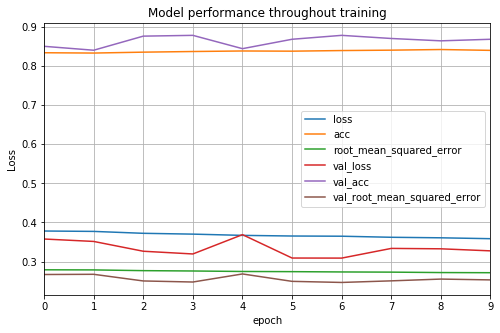

In [11]:
DataFrame(history.history).plot(figsize=(8, 5))#, logy=True)
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
valid_generator_eval = valid_datagen.flow_from_directory(
        './test',
        target_size=input_shape,
        batch_size=50,
        class_mode='categorical',
        shuffle=False,
        seed=SEED)

Found 18474 images belonging to 3 classes.


In [13]:
y_pred = model.predict_generator(valid_generator_eval)
y_pred.shape

(18474, 3)

In [14]:
valid_generator_eval.batch_size = valid_generator_eval.samples
y_valid = valid_generator_eval.next()[1]

In [15]:
y_valid.shape

(18474, 3)

In [16]:
y_pred.argmax(axis=1)

array([0, 0, 0, ..., 0, 1, 1])

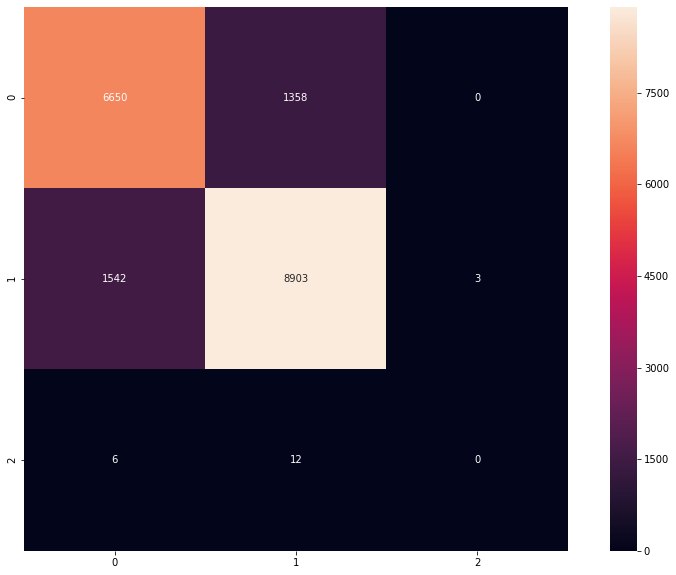

Accuracy= 0.841885893688427


In [17]:
y_valid_class = y_valid.argmax(axis=1)
y_valid_pred_class = y_pred.argmax(axis=1)
conf_mat = confusion_matrix(y_valid_class, y_valid_pred_class)
plt.figure(figsize=(15,10))
sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f')
plt.show()
print('Accuracy=', accuracy_score(y_valid_class, y_valid_pred_class))